<a href="https://colab.research.google.com/github/valentinaechavarria/-web-traffic-forecasting-project/blob/develop/1_entregaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Necessary Imports for the project

A continuacion importamos las librerias necesarias para trabajar con los datos.

In [30]:
!pip install pystan~=2.14
!pip install fbprophet
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Creamos las credenciales para poder descargar los datos de Kaggle. 

In [32]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"valenporras","key":"42ea9d695300e67193e4fd2387660ba5"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
%%bash
export KAGGLE_CONFIG_DIR=~/.kaggle/
kaggle competitions download web-traffic-time-series-forecasting -f key_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f key_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_2.csv.zip

key_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
key_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


Aca podemos evidenciar que los datos estan cargados y descomprimidos correctamente

In [34]:
cd /content

/content


In [35]:
!unzip -o key_1.csv.zip
!unzip -o key_2.csv.zip
!unzip -o sample_submission_1.csv.zip
!unzip -o sample_submission_2.csv.zip
!unzip -o train_1.csv.zip
!unzip -o train_2.csv.zip

Archive:  key_1.csv.zip
  inflating: key_1.csv               
Archive:  key_2.csv.zip
  inflating: key_2.csv               
Archive:  sample_submission_1.csv.zip
  inflating: sample_submission_1.csv  
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [36]:
ls

key_1.csv      sample_submission_1.csv      train_1.csv.zip
key_1.csv.zip  sample_submission_1.csv.zip  train_2.csv
key_2.csv      sample_submission_2.csv*     train_2.csv.zip
key_2.csv.zip  sample_submission_2.csv.zip
sample_data/   train_1.csv


# 1. Importing and Analyzing Data - Initial Approach

Aqui empezamos por analizar los datos que necesitamos para el forecasting



In [37]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math

%matplotlib inline

train = pd.read_csv("/content/train_1.csv")
keys = pd.read_csv("/content/key_1.csv")
ss = pd.read_csv("/content/sample_submission_1.csv")

In [38]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### Null Values

Hay datos que estan Null, esto nos impacta el analisis, por lo tanto tenemos que convertir esos datos a 0 

In [39]:
print("Total NaN Values: ", train.shape[0])
nan_values = train[train.isnull().any(axis=1)]
print("Total Records that are NaN: ", nan_values.shape[0])
nan_values.iloc[np.r_[0:10, len(nan_values)-10:len(nan_values)]]


Total NaN Values:  145063
Total Records that are NaN:  27786


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
10,ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,11.0,38.0,85.0,79.0,30.0,14.0,10.0,38.0,12.0,51.0
13,AlphaGo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,14.0,17.0,19.0,56.0,21.0,13.0,21.0,11.0
19,B-PROJECT_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,26.0,10.0,5.0,5.0,11.0,10.0,4.0,8.0,6.0
24,BLACK_PINK_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,56.0,39.0,65.0,78.0,143.0,96.0,63.0,28.0,75.0
27,Beautiful_Mind_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,8.0,6.0,7.0,2.0,11.0,11.0,29.0,12.0,14.0
37,Dear_My_Friends_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,12.0,8.0,12.0,3.0,10.0,21.0,6.0,8.0,9.0
38,Doctors_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,19.0,175.0,17.0,21.0,30.0,65.0,70.0,18.0,68.0
48,Fantastic_Duo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,15.0,11.0,10.0,7.0,12.0,9.0,8.0,10.0


### Visualizing the Data

A continuacion mostramos algunas time series.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22478 missing from current font.
  font.set_

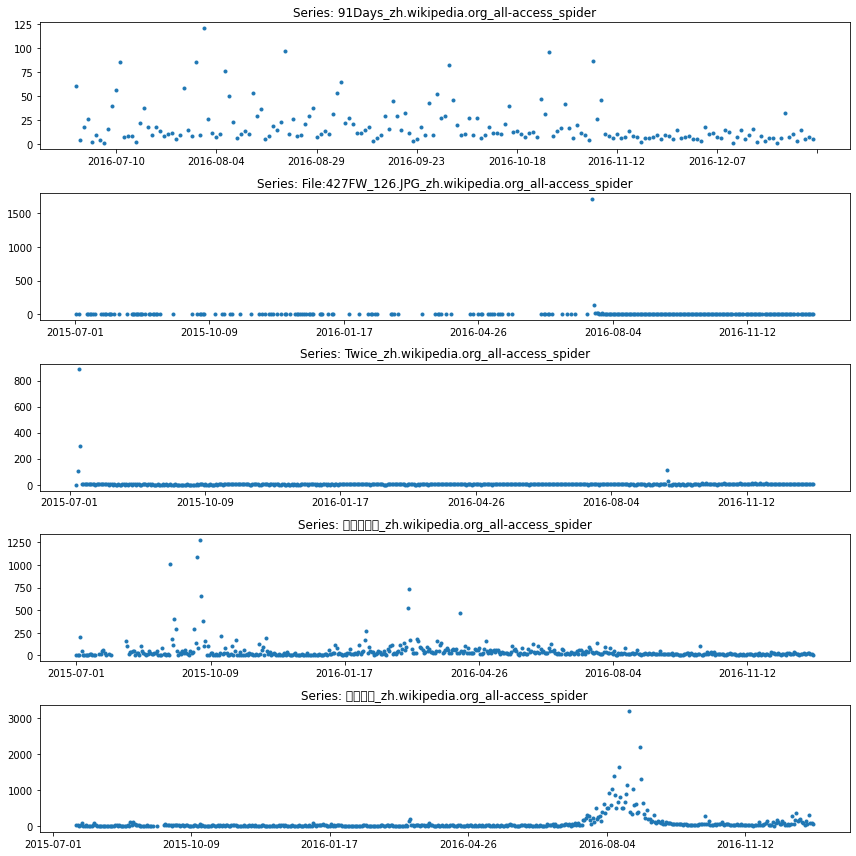

In [40]:
def plot_time_series(data_frame, row_num, start_col =1, ax=None):
    if ax is None:
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = data_frame.iloc[row_num, 0]
    sample_series = data_frame.iloc[row_num, start_col:]
    sample_series.plot(style=".", ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs  = plt.subplots(5,1,figsize=(12,12))
plot_time_series(nan_values, 1, ax=axs[0])
plot_time_series(nan_values, 10, ax=axs[1])
plot_time_series(nan_values, 50, ax=axs[2])
plot_time_series(nan_values, 100, ax=axs[3])
plot_time_series(nan_values, 200, ax=axs[4])

plt.tight_layout()